<a href="https://colab.research.google.com/github/tackulus/204383/blob/main/Code03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **03 Histogram Equalization**

> **204383 Image Processing** 

---

> **Kasidis Torcharoen (610510531)** \\
**Kittisak Thammawong (610510611)**

In [1]:
import numpy as np
import cv2 as cv 
from google.colab.patches import cv2_imshow
from skimage import io
import matplotlib.pylab as plt

In [2]:
url = "/content/0301.jpg"

image = io.imread(url)
image = cv.resize(image, (360, 640))
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

## **Method 1 : Independent channel equalization.**

---

In [3]:
def histeq1(im):
    """ Independent channel equalization  """

    saved_lst = []
    im_new = np.array(im)
    for c in range(3):

        # image's channel
        channel = np.array(im_new[:,:,c])

        # histogram
        imhist, bins = np.histogram(channel.flatten(), bins=256, range=(0,256))

        # cumulative distribution function
        # cumulative histogram
        cdf = imhist.cumsum()

        # normalized cumulative histogram
        masked = np.ma.masked_equal(cdf,0)
        normalized = 255 * ( masked - masked.min() ) / ( masked.max() - masked.min() )
        normalized = np.ma.filled(normalized, 0).astype("uint8")
    
        adjusted = np.array(normalized[channel])
        im_new[:,:,c] = adjusted
        saved_lst.append([channel, adjusted])
    
    im_new = im_new.astype("uint8")

    return im_new, zip([image , im_new], *saved_lst)

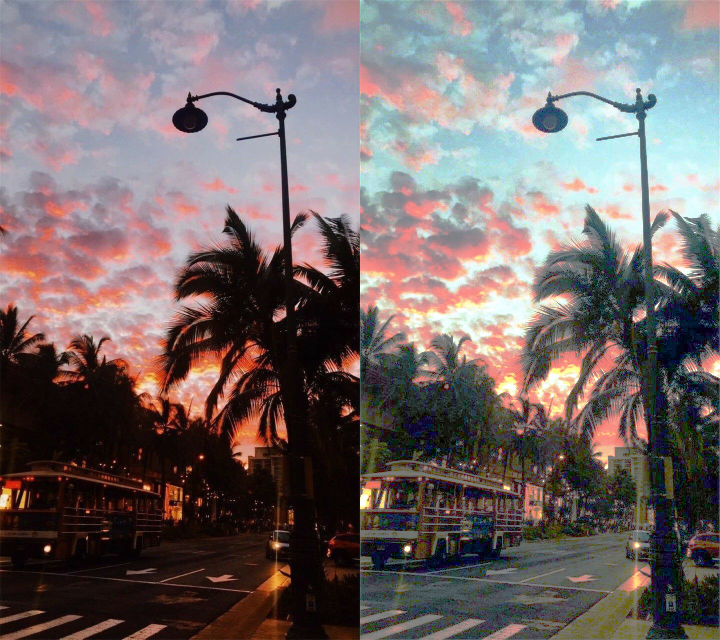

In [4]:
new_image1, pact1 = histeq1(image)
frame = cv.hconcat((image, new_image1))
cv2_imshow(frame)

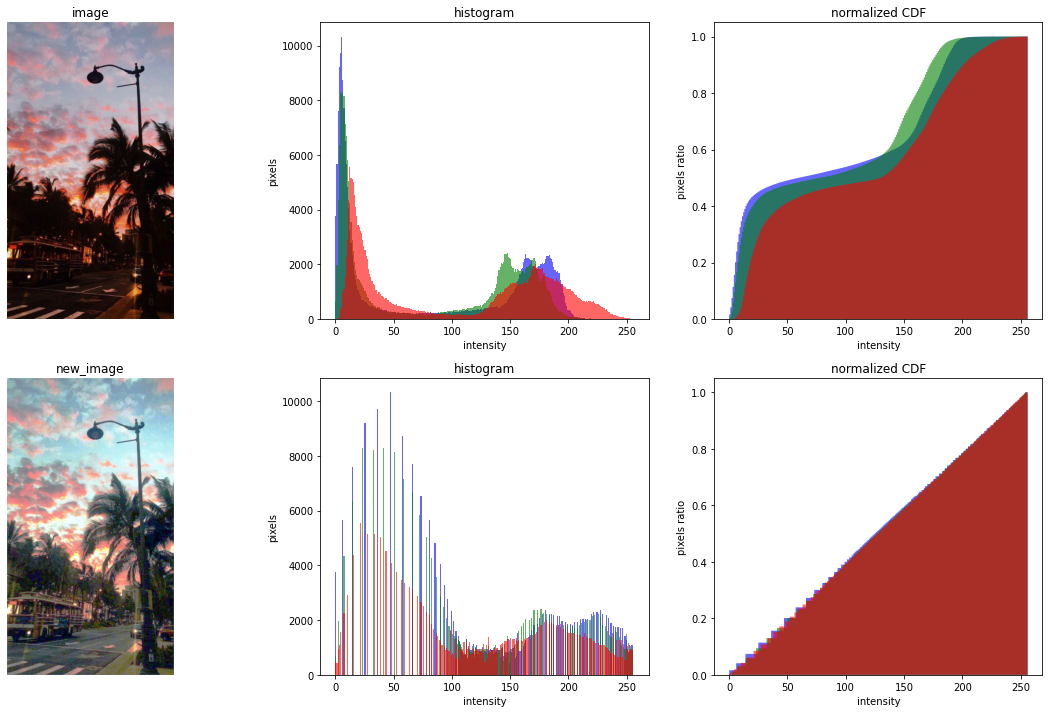

In [5]:
#@title  { display-mode: "form" }

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

for i, (imx, b, g, r) in enumerate(pact1):
    im = cv.cvtColor(imx, cv.COLOR_RGB2BGR)

    lst = ["image", "new_image"]
    ax[i,0].set_title(lst[i])
    ax[i,0].axis("off")
    ax[i,0].imshow(im)

    ax[i,1].set_title("histogram")
    ax[i,1].set_xlabel("intensity")
    ax[i,1].set_ylabel("pixels")

    for channel, c in zip([b, g, r], ['b', 'g', 'r']):
        ax[i,1].hist(channel.flatten(), bins=256, range=(0,256),
                     color=c, alpha=0.6)

    ax[i,2].set_title("normalized CDF")
    ax[i,2].set_xlabel("intensity")
    ax[i,2].set_ylabel("pixels ratio")
    for channel, c in zip([b, g, r], ['b', 'g', 'r']):
        ax[i,2].hist(channel.flatten(), bins=256, range=(0,256),
                    color=c, alpha=0.6, histtype='stepfilled',
                    density=True, cumulative=True)
    
plt.show()

## **Method 2 : Average channel's histogram equalization.**

---

In [6]:
def histeq2(im):
    """ Average channel's histogram equalization  """

    saved_lst = []
    hist_lst = []
    im_new = np.array(im)
    for c in range(3):
        # image's channel
        channel = np.array(im_new[:,:,c])

        # histogram
        imhist, bins = np.histogram(channel.flatten(), bins=256, range=(0,256))
        hist_lst.append(imhist)
        
    array = np.array(hist_lst)
    # cumulative distribution function
    # cumulative histogram
    cdf = np.average(array, axis=0).cumsum()
    
    # normalized cumulative histogram
    masked = np.ma.masked_equal(cdf,0)
    normalized = 255 * ( masked - masked.min() ) / ( masked.max() - masked.min() )
    normalized = np.ma.filled(normalized, 0).astype("uint8")

    for c in range(3):
        # image's channel
        channel = np.array(im_new[:,:,c])
        adjusted = np.array(normalized[channel])
        im_new[:,:,c] = adjusted
        saved_lst.append([channel, adjusted])
    
    im_new = im_new.astype("uint8")

    return im_new, zip([image , im_new], *saved_lst)

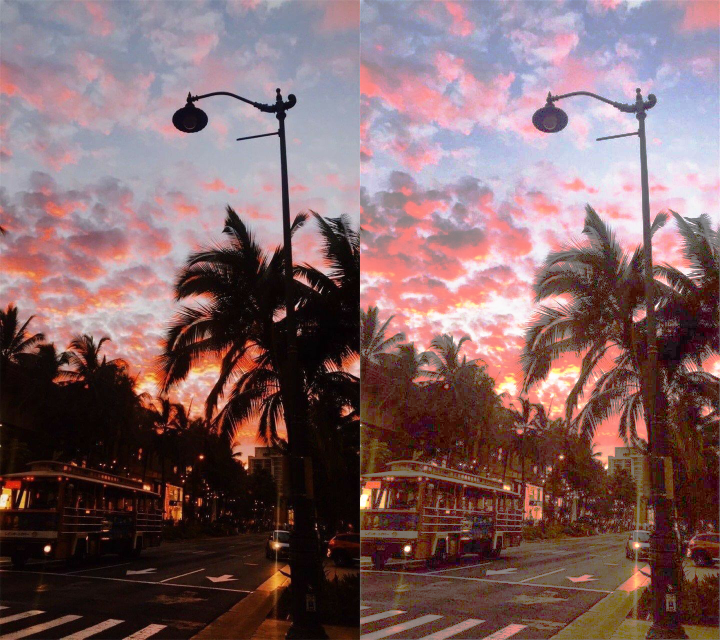

In [7]:
new_image2, pact2 = histeq2(image)
frame = cv.hconcat((image, new_image2))
cv2_imshow(frame)

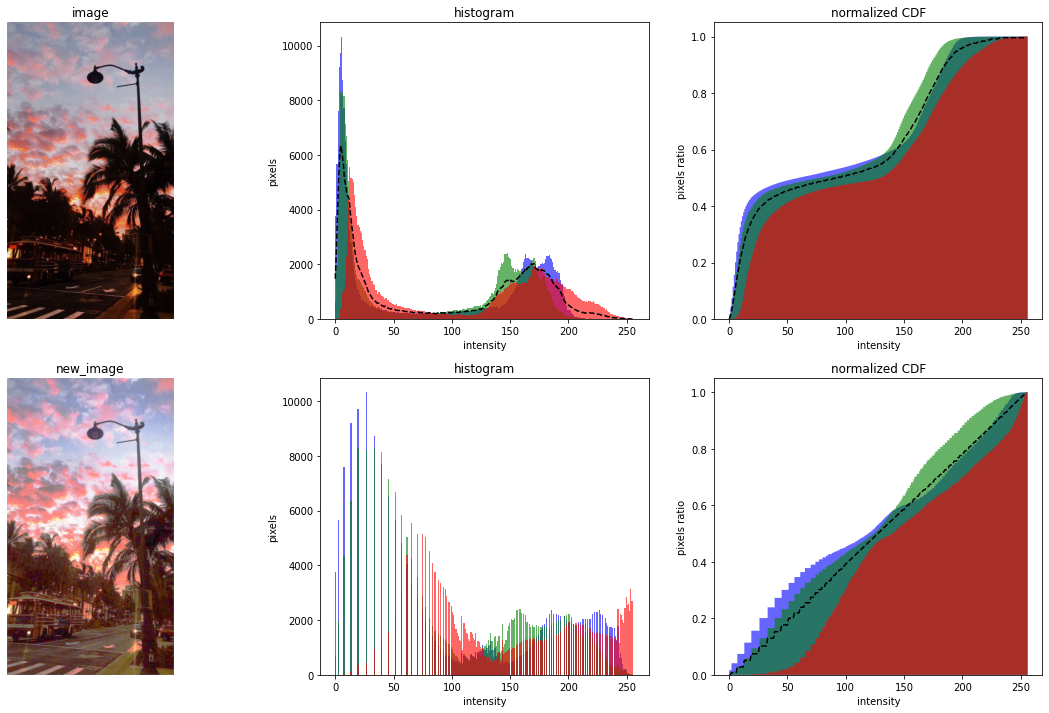

In [8]:
#@title  { display-mode: "form" }

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

for i, (imx, b, g, r) in enumerate(pact2):
    im = cv.cvtColor(imx, cv.COLOR_RGB2BGR)
    
    hist_lst = []
    for channel in [b, g, r]:
        imhist, bins = np.histogram(channel.flatten(), bins=256, range=(0,256))
        hist_lst.append(imhist)
            
    array = np.array(hist_lst)
    # cumulative distribution function
    # cumulative histogram
    avg = np.average(array, axis=0)
    cdf = avg.cumsum()
    masked = np.ma.masked_equal(cdf,0)
    normalized = 255 * ( masked - masked.min() ) / ( masked.max() - masked.min() )
    normalized = np.ma.filled(normalized, 0).astype("uint8") / 255.0

    lst = ["image", "new_image"]
    ax[i,0].set_title(lst[i])
    ax[i,0].axis("off")
    ax[i,0].imshow(im)

    ax[i,1].set_title("histogram")
    ax[i,1].set_xlabel("intensity")
    ax[i,1].set_ylabel("pixels")

    for channel, c in zip([b, g, r], ['b', 'g', 'r']):
        ax[i,1].hist(channel.flatten(), bins=256, range=(0,256),
                     color=c, alpha=0.6)

    if i==0: ax[i,1].plot(avg, ls="--", color='k', alpha=1)

    ax[i,2].set_title("normalized CDF")
    ax[i,2].set_xlabel("intensity")
    ax[i,2].set_ylabel("pixels ratio")
    ax[i,2].plot(normalized, ls="--", color='k', alpha=1)
    
    for channel, c in zip([b, g, r], ['b', 'g', 'r']):
        ax[i,2].hist(channel.flatten(), bins=256, range=(0,256),
                    color=c, alpha=0.6, histtype='stepfilled',
                    density=True, cumulative=True)
    
plt.show()

## **Method 3 : Intensity component equalization.**

---

In [9]:
def histeq3(im):
    """ Intensity component equalization.  """

    # image's luminance
    im_new = cv.cvtColor(im, cv.COLOR_RGB2YUV)
    luminance = np.array(im_new[:,:,0])

    # histogram
    imhist, bins = np.histogram(luminance.flatten(), bins=256, range=(0,256))

    # cumulative distribution function
    # cumulative histogram
    cdf = imhist.cumsum()

    # normalized cumulative histogram
    masked = np.ma.masked_equal(cdf,0)
    normalized = 255 * ( masked - masked.min() ) / ( masked.max() - masked.min() )
    normalized = np.ma.filled(normalized, 0).astype("uint8")
    
    adjusted = normalized[luminance]
    im_new[:,:,0] = adjusted
    im_new = cv.cvtColor(im_new, cv.COLOR_YUV2RGB)
    im_new = im_new.astype("uint8")

    pact = zip([image , im_new], [luminance, adjusted])

    return ( im_new, pact )

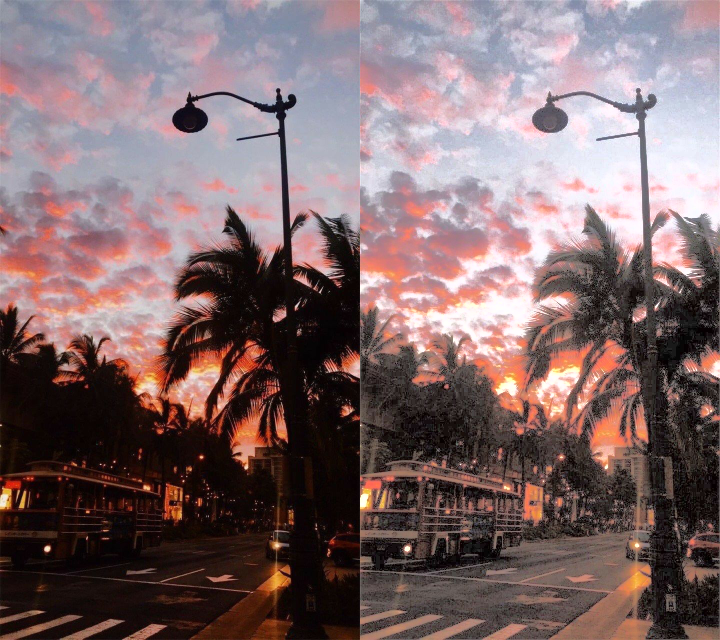

In [10]:
new_image3, pact3 = histeq3(image)
frame = cv.hconcat((image, new_image3))
cv2_imshow(frame)

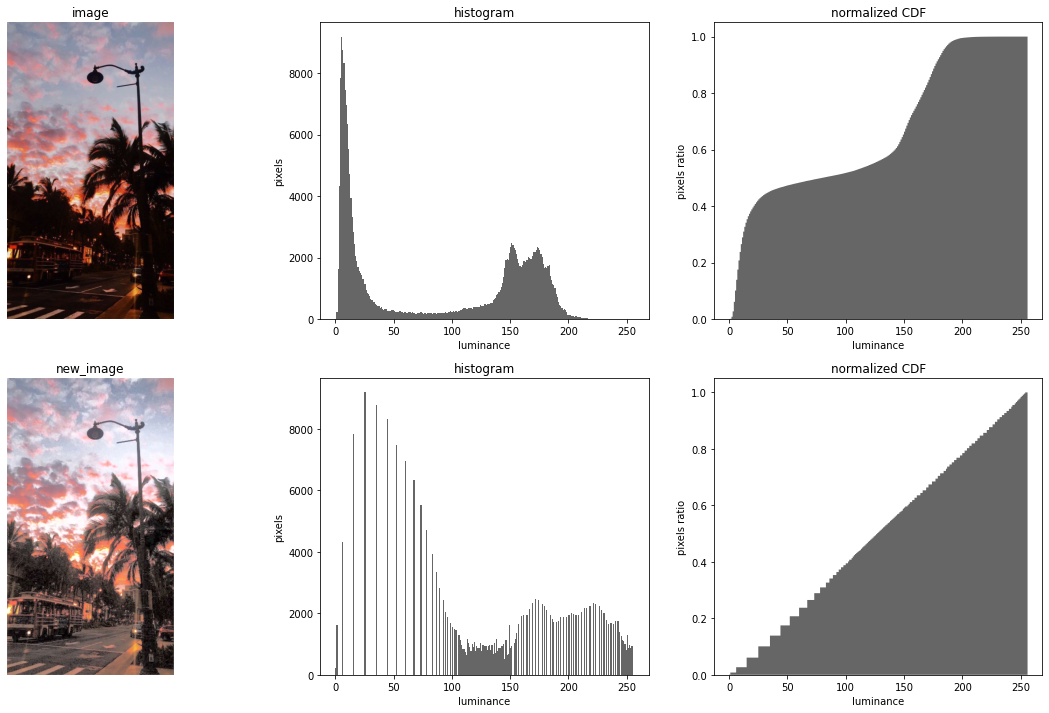

In [11]:
#@title  { display-mode: "form" }

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

for i, (imx, lum) in enumerate(pact3):
    im = cv.cvtColor(imx, cv.COLOR_RGB2BGR)

    lst = ["image", "new_image"]
    ax[i,0].set_title(lst[i])
    ax[i,0].axis("off")
    ax[i,0].imshow(im)

    ax[i,1].set_title("histogram")
    ax[i,1].set_xlabel("luminance")
    ax[i,1].set_ylabel("pixels")
    ax[i,1].hist(lum.flatten(), bins=256, range=(0,256),
                 color='k', alpha=0.6)

    ax[i,2].set_title("normalized CDF")
    ax[i,2].set_xlabel("luminance")
    ax[i,2].set_ylabel("pixels ratio")
    ax[i,2].hist(lum.flatten(), bins=256, range=(0,256),
                 color='k', alpha=0.6, histtype='stepfilled',
                 density=True, cumulative=True)
    
plt.show()

## **Method 4 : Using build-in function** *cv.equalizeHist* .

---

In [12]:
def histeq2(im):
    """ Histogram equalization of a color image.  """

    im_new = cv.cvtColor(im, cv.COLOR_RGB2YUV)
    im_new[:,:,0] = cv.equalizeHist(im_new[:,:,0])
    im_new = cv.cvtColor(im_new, cv.COLOR_YUV2RGB)

    return im_new

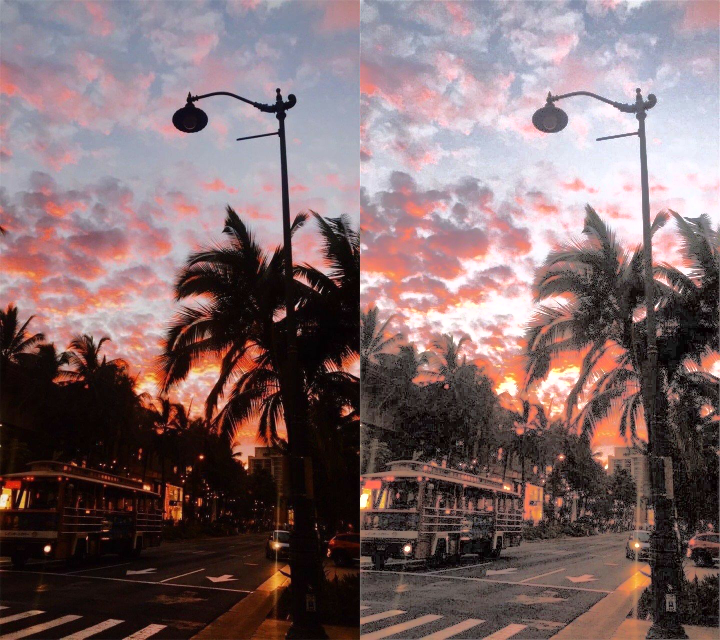

In [13]:
new_image = histeq2(image)
frame = cv.hconcat((image, new_image))
cv2_imshow(frame)